# Apply AI Superresolution to video - Predict using RCAN pretrained models - a patch 48x48

https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long - complete
- set kernel range from 1 to 20 - vs 4-20 need lower range too - complete
- combination of hi res perceptual and mse on smoothed versions of input.- complete
- give more emphasis to mse

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up
- better model and apply to all 3 colors
- try vgg perception metric
- focus prediction


RCAN Results
- Uses lots of resources as scale of image increases
- Does not handle different scales well
- not meant for restoration - 
To try
- Apply pretrained model on a patch thats 48x48 then can judge if its worth making an approach to apply repeatedly to larger images.
- train vdsr with a convolutional upscaling up front, attention, residuals.






## Share results
- put out an example on youtube to allow comparison



# Project Documentation

In [1]:
from pathlib import Path
import os


project_base = "/media/SSD/superres/"
results_folder = "Results"
data_folder = "video_data"
model_folder = "checkpoint"

model_name_base = "RCAN"



## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution RCAN predict patch.ipynb


In [4]:


nb_path = Path(NOTEBOOK_FULL_PATH)
print(nb_path)

# Make result folder if it does not exist
result_path = Path(project_base, results_folder , nb_path.stem )
print(result_path)
os.makedirs(result_path, exist_ok=True)

/SSD_link/superres/Superresolution RCAN predict patch.ipynb
/media/SSD/superres/Results/Superresolution RCAN predict patch


In [5]:
model_out_path=Path(project_base)/model_folder
print(model_out_path)
os.makedirs(model_out_path, exist_ok=True)

/media/SSD/superres/checkpoint


In [6]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [7]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange

import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [8]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

In [10]:
from superres_utils import make_framelist, load_frame, RescaleCrop, Multifuz, DatasetFromVideoFolder
from superres_utils import show_batch
from superres_utils import pil_disk_blur, display_PSNR, test_results, superres_mp4
from superres_utils import batch_tensor_to_cv2, cv2_to_batch_tensor

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [9]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp"])



In [10]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [11]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data/train_data",1)

In [12]:
instances

[{'Filepath': '/media/SSD/superres/video_data/train_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/train_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/train_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/train_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/train_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/train_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/train_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/train_data/102797996.mp4',
  'Type': 'frame',
  'F

In [13]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [14]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [15]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        if self.size is not None:
            input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [16]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [17]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [18]:
class Crappify(object):


    def __init__(self, crop_size ,kernel_size, quality):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_size = kernel_size
        self.quality = quality

    
        

    def __call__(self, img):
        
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(self.kernel_size)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        if self.crop_size is not None:
            img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,self.quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [19]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [20]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


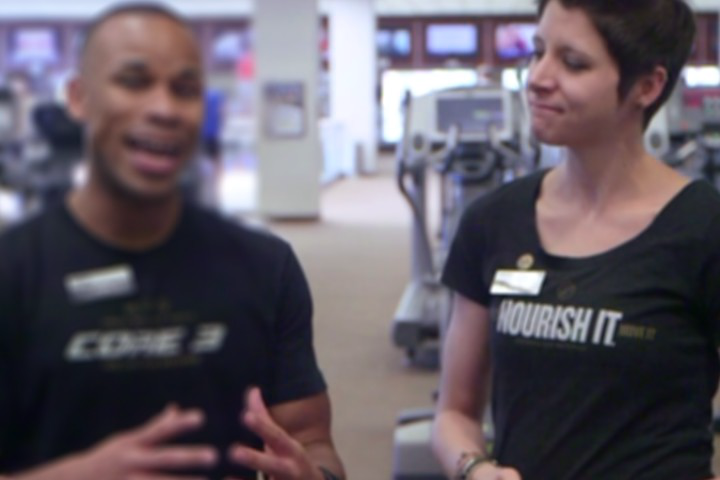

In [21]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,16), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [22]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        #Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        #Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        Resize((48*4,48*4), interpolation=Image.BICUBIC),
        ToTensor(),
    ])



def test_input_transform(crop_size, kernel_size, quality):
    
    return Compose([
        Crappify(crop_size=crop_size, kernel_size=kernel_size, quality=quality),
        ToTensor()
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, kernel_size, quality, frame_sample_size=10):


    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=test_input_transform(
                                 crop_size, kernel_size, quality),
                             target_transform=ToTensor(),
                             add_noise=None,
                             noise_std=3,Flip_hor=False,
                             Rand_bright_contrast=False)

In [25]:
#settings
train_dir = "/media/SSD/superres/video_data/train_data"
frame_sample_size =10
batch_size = 16 # Make 4 For FP16, 480x720 size images
#crop_size = (480,720)
crop_size = (48,48)
kernel_range=(1,10)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [26]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [27]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(48, 48)


In [28]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [29]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([16, 3, 48, 48])


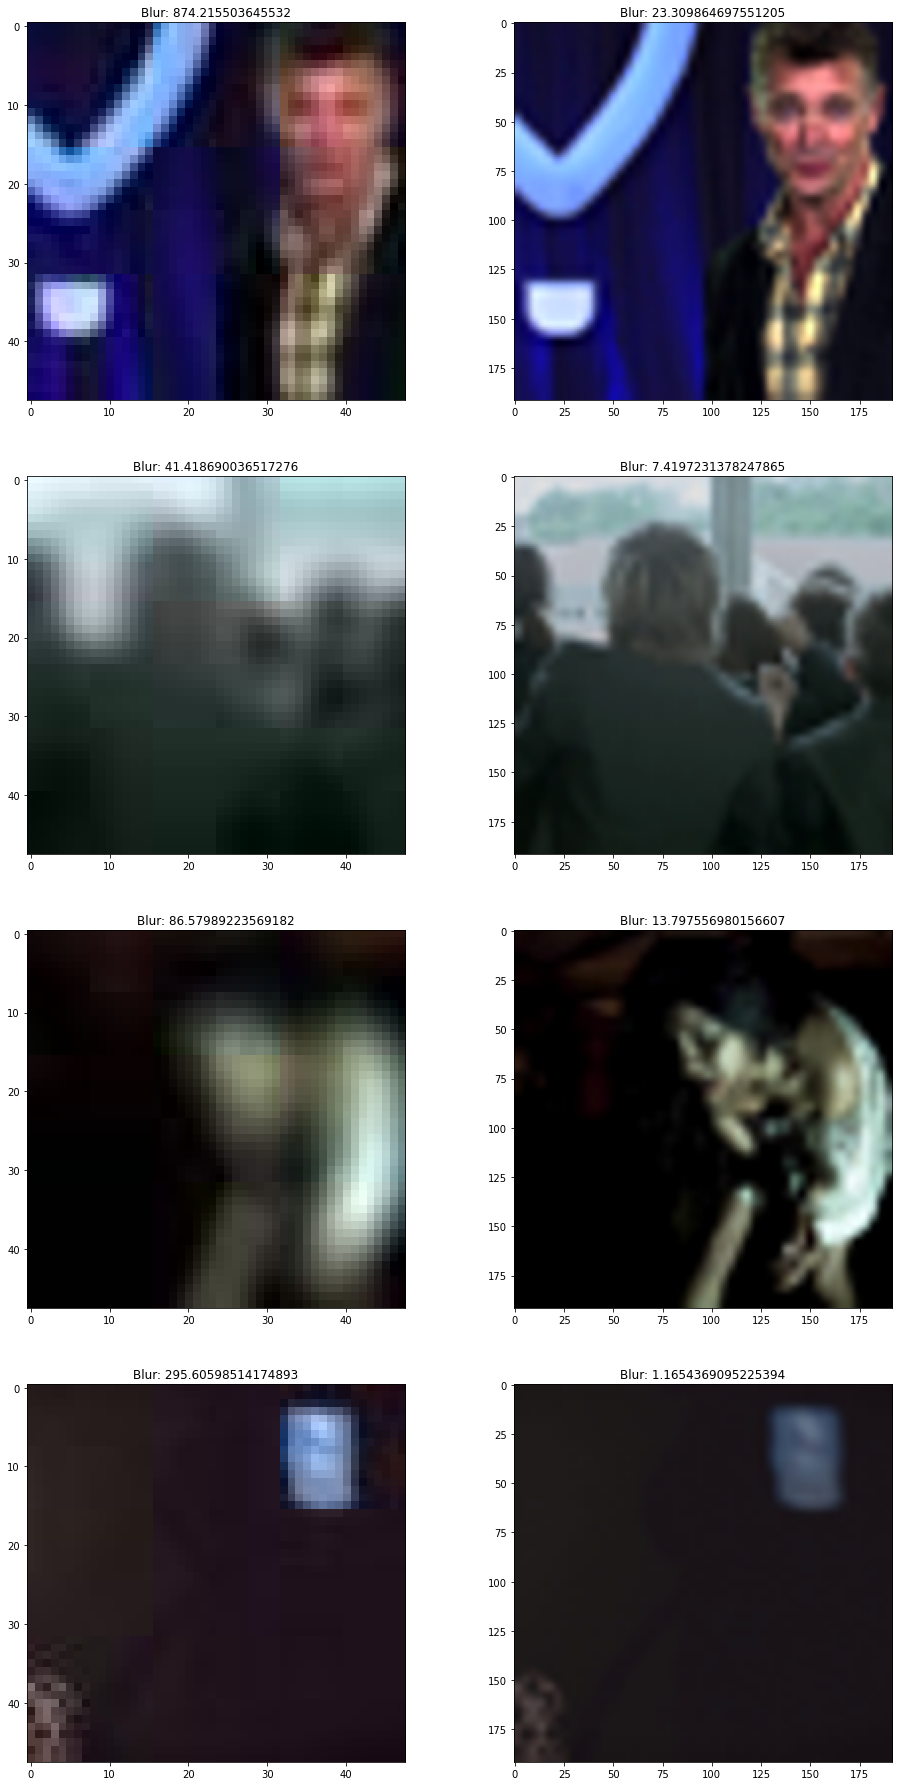

In [30]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class VDSRNet(nn.Module):
    def __init__(self):
        super(VDSRNet, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out
    
    


# ESPCN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))


class ESPCNNet(nn.Module):
    def __init__(self, upscale_factor):
        super(ESPCNNet, self).__init__()

        self.upscale_factor = upscale_factor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1a = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1b = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1c = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv1d = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 1 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        
        #residual = x
        #residual = F.interpolate(x, size=None, scale_factor=self.upscale_factor, mode='bicubic',
        #                         align_corners=True, recompute_scale_factor=None).clamp(min=0.0, max=1.0)
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.relu(self.conv1c(x))
        x = self.relu(self.conv1d(x))
        x = self.relu(self.conv2(x))
        x = F.sigmoid(self.pixel_shuffle(self.conv3(x)))
        
        #x = torch.add(x,residual)
        
        return x
    
# Make it use a residual approach -Add the network to bicubic interpolation at end resolution - just like VDSR

# RCAN

In [11]:
# common

import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.weight.data.div_(std.view(3, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False

class BasicBlock(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2), stride=stride, bias=bias)
        ]
        if bn: m.append(nn.BatchNorm2d(out_channels))
        if act is not None: m.append(act)
        super(BasicBlock, self).__init__(*m)

class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:    # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

In [12]:
import torch.nn as nn

def make_model(args, parent=False):
    return RCAN(args)

## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        #res = self.body(x).mul(self.res_scale)
        res += x
        return res

## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = []
        modules_body = [
            RCAB(
                conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) \
            for _ in range(n_resblocks)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

## Residual Channel Attention Network (RCAN)
class RCAN(nn.Module):
    def __init__(self, args, conv=default_conv):
        super(RCAN, self).__init__()
        
        n_resgroups = args.n_resgroups
        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3
        reduction = args.reduction 
        scale = args.scale[0]
        act = nn.ReLU(True)
        
        # RGB mean for DIV2K
        rgb_mean = (0.4488, 0.4371, 0.4040)
        rgb_std = (1.0, 1.0, 1.0)
        self.sub_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std)
        
        # define head module
        modules_head = [conv(args.n_colors, n_feats, kernel_size)]

        # define body module
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=args.res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]

        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, args.n_colors, kernel_size)]

        self.add_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std, 1)

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        #remove for single channel
        x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        #remove for single channel images
        x = self.add_mean(x)

        return x 

    def load_state_dict(self, state_dict, strict=False):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') >= 0:
                        print('Replace pre-trained upsampler to new one...')
                    else:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))

        if strict:
            missing = set(own_state.keys()) - set(state_dict.keys())
            if len(missing) > 0:
                raise KeyError('missing keys in state_dict: "{}"'.format(missing))

# Load the model from the paper

In [13]:
from types import SimpleNamespace

args = SimpleNamespace()

args.n_resgroups = 10 # was 10
args.n_resblocks = 20 # was 20
args.n_feats = 64
args.reduction = 16
args.scale = (4,0)
args.rgb_range = 255
args.n_colors = 3
args.res_scale = 1


In [14]:
model = RCAN(args)
model.cuda()


RCAN(
  (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResidualGroup(
      (body): Sequential(
        (0): RCAB(
          (body): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): CALayer(
              (avg_pool): AdaptiveAvgPool2d(output_size=1)
              (conv_du): Sequential(
                (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
                (1): ReLU(inplace=True)
                (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
                (3): Sigmoid()
              )
            )
          )
        )
        (1): RCAB(
          (body): Sequential(
       

In [15]:

#model = torch.load("/media/SSD/superres/models_ECCV2018RCAN/RCAN_BIX2.pt")


In [16]:
model.load_state_dict(torch.load("/media/SSD/superres/models_ECCV2018RCAN/RCAN_BIX4.pt"),strict=False)

In [ ]:
#model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



In [36]:
criterion = nn.MSELoss(reduction = 'sum')


In [37]:
init_lr = .0001
lr_step = 4
gradient_clip = 0.4
epochs = 20

In [38]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [39]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [40]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [41]:
def save_checkpoint(experiment, model, epoch):

    model_out_str = str(model_out_path/(model_name_base+"_epoch_{}.pth")).format(epoch)
    
    state = {"experiment": experiment, "epoch": epoch ,"model": model}

    torch.save(state, model_out_str)

    print("Checkpoint saved to {}".format(model_out_str))

In [42]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [43]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            output = model(input)
            #loss = criterion(output, target) + criterion2(output, target)/5000.0
            loss = criterion(output, target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [44]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(NOTEBOOK_FULL_PATH, model, epoch)

Start Time: 2020-10-03 14:05:43.673088
Epoch = 1, lr = 0.0001
===> Time: 2020-10-03 14:06:03.922893 Epoch[1](10/397): LR: 0.0001 : Loss: 1608.9154052734
===> Time: 2020-10-03 14:06:24.095717 Epoch[1](20/397): LR: 0.0001 : Loss: 1606.0150146484
===> Time: 2020-10-03 14:06:44.738992 Epoch[1](30/397): LR: 0.0001 : Loss: 209974.8593750000
===> Time: 2020-10-03 14:07:06.266517 Epoch[1](40/397): LR: 0.0001 : Loss: 113889.3906250000
===> Time: 2020-10-03 14:07:27.269340 Epoch[1](50/397): LR: 0.0001 : Loss: 16986.3261718750
===> Time: 2020-10-03 14:07:48.388759 Epoch[1](60/397): LR: 0.0001 : Loss: 10369.4023437500
===> Time: 2020-10-03 14:08:09.418983 Epoch[1](70/397): LR: 0.0001 : Loss: 6341.2495117188
===> Time: 2020-10-03 14:08:31.072965 Epoch[1](80/397): LR: 0.0001 : Loss: 4256.4819335938
===> Time: 2020-10-03 14:08:51.757632 Epoch[1](90/397): LR: 0.0001 : Loss: 4295.6513671875
===> Time: 2020-10-03 14:09:13.314017 Epoch[1](100/397): LR: 0.0001 : Loss: 3874.6469726562
===> Time: 2020-10-03

===> Time: 2020-10-03 14:34:44.830313 Epoch[3](80/397): LR: 0.0001 : Loss: 6656.6494140625
===> Time: 2020-10-03 14:35:04.193210 Epoch[3](90/397): LR: 0.0001 : Loss: 7781.3320312500
===> Time: 2020-10-03 14:35:23.282938 Epoch[3](100/397): LR: 0.0001 : Loss: 7954.2182617188
===> Time: 2020-10-03 14:35:41.989525 Epoch[3](110/397): LR: 0.0001 : Loss: 4964.9155273438
===> Time: 2020-10-03 14:36:01.130360 Epoch[3](120/397): LR: 0.0001 : Loss: 6810.6518554688
===> Time: 2020-10-03 14:36:20.352540 Epoch[3](130/397): LR: 0.0001 : Loss: 4648.8154296875
===> Time: 2020-10-03 14:36:39.394633 Epoch[3](140/397): LR: 0.0001 : Loss: 4485.3505859375
===> Time: 2020-10-03 14:36:58.585446 Epoch[3](150/397): LR: 0.0001 : Loss: 4845.0893554688
===> Time: 2020-10-03 14:37:17.285466 Epoch[3](160/397): LR: 0.0001 : Loss: 4402.9765625000
===> Time: 2020-10-03 14:37:36.552076 Epoch[3](170/397): LR: 0.0001 : Loss: 4709.9536132812
===> Time: 2020-10-03 14:37:55.884904 Epoch[3](180/397): LR: 0.0001 : Loss: 4286.7

===> Time: 2020-10-03 15:01:27.846957 Epoch[5](140/397): LR: 3.1622776601683795e-05 : Loss: 1776.7535400391
===> Time: 2020-10-03 15:01:46.384496 Epoch[5](150/397): LR: 3.1622776601683795e-05 : Loss: 1823.8762207031
===> Time: 2020-10-03 15:02:05.468179 Epoch[5](160/397): LR: 3.1622776601683795e-05 : Loss: 1928.6761474609
===> Time: 2020-10-03 15:02:24.172783 Epoch[5](170/397): LR: 3.1622776601683795e-05 : Loss: 1899.9414062500
===> Time: 2020-10-03 15:02:42.766622 Epoch[5](180/397): LR: 3.1622776601683795e-05 : Loss: 3133.1169433594
===> Time: 2020-10-03 15:03:01.283346 Epoch[5](190/397): LR: 3.1622776601683795e-05 : Loss: 2310.3720703125
===> Time: 2020-10-03 15:03:20.076571 Epoch[5](200/397): LR: 3.1622776601683795e-05 : Loss: 2029.2926025391
===> Time: 2020-10-03 15:03:38.884578 Epoch[5](210/397): LR: 3.1622776601683795e-05 : Loss: 3040.0104980469
===> Time: 2020-10-03 15:03:57.303479 Epoch[5](220/397): LR: 3.1622776601683795e-05 : Loss: 2723.1442871094
===> Time: 2020-10-03 15:04:

===> Time: 2020-10-03 15:24:42.050481 Epoch[7](90/397): LR: 3.1622776601683795e-05 : Loss: 2699.4753417969
===> Time: 2020-10-03 15:25:00.748947 Epoch[7](100/397): LR: 3.1622776601683795e-05 : Loss: 2622.1315917969
===> Time: 2020-10-03 15:25:19.482803 Epoch[7](110/397): LR: 3.1622776601683795e-05 : Loss: 3122.2409667969
===> Time: 2020-10-03 15:25:38.094308 Epoch[7](120/397): LR: 3.1622776601683795e-05 : Loss: 2709.6772460938
===> Time: 2020-10-03 15:25:56.650386 Epoch[7](130/397): LR: 3.1622776601683795e-05 : Loss: 2468.8825683594
===> Time: 2020-10-03 15:26:15.208546 Epoch[7](140/397): LR: 3.1622776601683795e-05 : Loss: 3663.9890136719
===> Time: 2020-10-03 15:26:34.342415 Epoch[7](150/397): LR: 3.1622776601683795e-05 : Loss: 3431.7292480469
===> Time: 2020-10-03 15:26:53.242546 Epoch[7](160/397): LR: 3.1622776601683795e-05 : Loss: 3150.5954589844
===> Time: 2020-10-03 15:27:12.076290 Epoch[7](170/397): LR: 3.1622776601683795e-05 : Loss: 4380.6254882812
===> Time: 2020-10-03 15:27:3

===> Time: 2020-10-03 15:48:14.197078 Epoch[9](50/397): LR: 1e-05 : Loss: 2682.1940917969
===> Time: 2020-10-03 15:48:32.708976 Epoch[9](60/397): LR: 1e-05 : Loss: 2178.4821777344
===> Time: 2020-10-03 15:48:51.677016 Epoch[9](70/397): LR: 1e-05 : Loss: 2086.1511230469
===> Time: 2020-10-03 15:49:10.877244 Epoch[9](80/397): LR: 1e-05 : Loss: 1939.2219238281
===> Time: 2020-10-03 15:49:29.445410 Epoch[9](90/397): LR: 1e-05 : Loss: 2021.9849853516
===> Time: 2020-10-03 15:49:48.574277 Epoch[9](100/397): LR: 1e-05 : Loss: 1794.1981201172
===> Time: 2020-10-03 15:50:07.462462 Epoch[9](110/397): LR: 1e-05 : Loss: 2059.9907226562
===> Time: 2020-10-03 15:50:25.874354 Epoch[9](120/397): LR: 1e-05 : Loss: 1881.4754638672
===> Time: 2020-10-03 15:50:44.660932 Epoch[9](130/397): LR: 1e-05 : Loss: 2427.1328125000
===> Time: 2020-10-03 15:51:03.180735 Epoch[9](140/397): LR: 1e-05 : Loss: 2870.1364746094
===> Time: 2020-10-03 15:51:21.858891 Epoch[9](150/397): LR: 1e-05 : Loss: 2302.2399902344
===>

===> Time: 2020-10-03 16:15:29.193992 Epoch[11](130/397): LR: 1e-05 : Loss: 1651.9344482422
===> Time: 2020-10-03 16:15:48.058045 Epoch[11](140/397): LR: 1e-05 : Loss: 1545.7830810547
===> Time: 2020-10-03 16:16:06.798044 Epoch[11](150/397): LR: 1e-05 : Loss: 1587.3167724609
===> Time: 2020-10-03 16:16:25.647998 Epoch[11](160/397): LR: 1e-05 : Loss: 1802.7047119141
===> Time: 2020-10-03 16:16:44.354245 Epoch[11](170/397): LR: 1e-05 : Loss: 1733.7659912109
===> Time: 2020-10-03 16:17:03.223620 Epoch[11](180/397): LR: 1e-05 : Loss: 1860.2532958984
===> Time: 2020-10-03 16:17:22.067559 Epoch[11](190/397): LR: 1e-05 : Loss: 1519.6105957031
===> Time: 2020-10-03 16:17:41.065956 Epoch[11](200/397): LR: 1e-05 : Loss: 1479.9272460938
===> Time: 2020-10-03 16:17:59.840955 Epoch[11](210/397): LR: 1e-05 : Loss: 1748.8984375000
===> Time: 2020-10-03 16:18:18.827106 Epoch[11](220/397): LR: 1e-05 : Loss: 1627.0910644531
===> Time: 2020-10-03 16:18:37.682815 Epoch[11](230/397): LR: 1e-05 : Loss: 1948

===> Time: 2020-10-03 16:41:51.890956 Epoch[13](180/397): LR: 3.16227766016838e-06 : Loss: 1630.9725341797
===> Time: 2020-10-03 16:42:10.449266 Epoch[13](190/397): LR: 3.16227766016838e-06 : Loss: 1817.1610107422
===> Time: 2020-10-03 16:42:28.583795 Epoch[13](200/397): LR: 3.16227766016838e-06 : Loss: 1564.9486083984
===> Time: 2020-10-03 16:42:47.490591 Epoch[13](210/397): LR: 3.16227766016838e-06 : Loss: 1660.7874755859
===> Time: 2020-10-03 16:43:06.526658 Epoch[13](220/397): LR: 3.16227766016838e-06 : Loss: 1617.7363281250
===> Time: 2020-10-03 16:43:25.391403 Epoch[13](230/397): LR: 3.16227766016838e-06 : Loss: 1484.0187988281
===> Time: 2020-10-03 16:43:44.359880 Epoch[13](240/397): LR: 3.16227766016838e-06 : Loss: 1826.8870849609
===> Time: 2020-10-03 16:44:02.838007 Epoch[13](250/397): LR: 3.16227766016838e-06 : Loss: 1390.2830810547
===> Time: 2020-10-03 16:44:21.078097 Epoch[13](260/397): LR: 3.16227766016838e-06 : Loss: 1682.4062500000
===> Time: 2020-10-03 16:44:40.019197

===> Time: 2020-10-03 17:05:22.905506 Epoch[15](140/397): LR: 3.16227766016838e-06 : Loss: 1783.0178222656
===> Time: 2020-10-03 17:05:41.420126 Epoch[15](150/397): LR: 3.16227766016838e-06 : Loss: 1620.4403076172
===> Time: 2020-10-03 17:06:00.679230 Epoch[15](160/397): LR: 3.16227766016838e-06 : Loss: 1387.3214111328
===> Time: 2020-10-03 17:06:19.493120 Epoch[15](170/397): LR: 3.16227766016838e-06 : Loss: 1571.9675292969
===> Time: 2020-10-03 17:06:38.095655 Epoch[15](180/397): LR: 3.16227766016838e-06 : Loss: 1461.8808593750
===> Time: 2020-10-03 17:06:57.148401 Epoch[15](190/397): LR: 3.16227766016838e-06 : Loss: 1548.8892822266
===> Time: 2020-10-03 17:07:15.995678 Epoch[15](200/397): LR: 3.16227766016838e-06 : Loss: 1718.8739013672
===> Time: 2020-10-03 17:07:34.777007 Epoch[15](210/397): LR: 3.16227766016838e-06 : Loss: 1479.5963134766
===> Time: 2020-10-03 17:07:53.833935 Epoch[15](220/397): LR: 3.16227766016838e-06 : Loss: 1814.9462890625
===> Time: 2020-10-03 17:08:12.926333

===> Time: 2020-10-03 17:28:39.832273 Epoch[17](90/397): LR: 1.0000000000000002e-06 : Loss: 1839.4963378906
===> Time: 2020-10-03 17:28:58.640425 Epoch[17](100/397): LR: 1.0000000000000002e-06 : Loss: 1447.2447509766
===> Time: 2020-10-03 17:29:17.429259 Epoch[17](110/397): LR: 1.0000000000000002e-06 : Loss: 1469.7193603516
===> Time: 2020-10-03 17:29:35.769830 Epoch[17](120/397): LR: 1.0000000000000002e-06 : Loss: 1877.1953125000
===> Time: 2020-10-03 17:29:54.282556 Epoch[17](130/397): LR: 1.0000000000000002e-06 : Loss: 1540.7263183594
===> Time: 2020-10-03 17:30:13.030945 Epoch[17](140/397): LR: 1.0000000000000002e-06 : Loss: 1660.7115478516
===> Time: 2020-10-03 17:30:31.471272 Epoch[17](150/397): LR: 1.0000000000000002e-06 : Loss: 1659.8934326172
===> Time: 2020-10-03 17:30:50.788895 Epoch[17](160/397): LR: 1.0000000000000002e-06 : Loss: 1831.2128906250
===> Time: 2020-10-03 17:31:09.754766 Epoch[17](170/397): LR: 1.0000000000000002e-06 : Loss: 1552.9816894531
===> Time: 2020-10-0

===> Time: 2020-10-03 17:51:34.236385 Epoch[19](30/397): LR: 1.0000000000000002e-06 : Loss: 1650.6884765625
===> Time: 2020-10-03 17:51:53.308714 Epoch[19](40/397): LR: 1.0000000000000002e-06 : Loss: 1390.1715087891
===> Time: 2020-10-03 17:52:12.083841 Epoch[19](50/397): LR: 1.0000000000000002e-06 : Loss: 1510.4476318359
===> Time: 2020-10-03 17:52:30.752786 Epoch[19](60/397): LR: 1.0000000000000002e-06 : Loss: 1416.9027099609
===> Time: 2020-10-03 17:52:49.846789 Epoch[19](70/397): LR: 1.0000000000000002e-06 : Loss: 1521.4790039062
===> Time: 2020-10-03 17:53:08.850811 Epoch[19](80/397): LR: 1.0000000000000002e-06 : Loss: 1586.6375732422
===> Time: 2020-10-03 17:53:27.419098 Epoch[19](90/397): LR: 1.0000000000000002e-06 : Loss: 1423.5065917969
===> Time: 2020-10-03 17:53:45.773055 Epoch[19](100/397): LR: 1.0000000000000002e-06 : Loss: 1399.1916503906
===> Time: 2020-10-03 17:54:04.614124 Epoch[19](110/397): LR: 1.0000000000000002e-06 : Loss: 1545.9620361328
===> Time: 2020-10-03 17:5

===> Time: 2020-10-03 18:14:55.937158 Epoch[20](380/397): LR: 1.0000000000000002e-06 : Loss: 1560.1818847656
===> Time: 2020-10-03 18:15:14.544946 Epoch[20](390/397): LR: 1.0000000000000002e-06 : Loss: 1474.6361083984
Epoch Loss: tensor(1585.7806, device='cuda:0')
Checkpoint saved to /media/SSD/superres/checkpoint/RCAN_epoch_20.pth


Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [45]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [46]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [17]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [48]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [49]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [70]:
from superres_utils import PSNR, colorize, decolorize, variance_of_laplacian
from torch.cuda.amp import autocast

ImportError: cannot import name 'cvdecolorize' from 'superres_utils' (/media/SSD/superres/superres_utils.py)

In [141]:
def cv2_to_batch_tensor(img_bgr):
    mn=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    im_rgb = im_rgb/255.0
    #im_rgb = (im_rgb-mn)/std
    tform = im_rgb.transpose(( 2,0, 1))
    tform = torch.from_numpy(tform).float()
    tform = tform.unsqueeze(0)
    return tform

In [142]:
def batch_tensor_to_cv2(bt_3ch):
    bt_3ch = (bt_3ch*255.0).float().clamp(0,255)
    t_3ch = bt_3ch.squeeze(0)
    #t_3ch = t_3ch.cpu()
    im_rbg = t_3ch.permute(1,2,0).numpy().astype(np.uint8)
    im_bgr = cv2.cvtColor(im_rbg, cv2.COLOR_RGB2BGR)
    
    return im_bgr

In [143]:
def display_PSNR(im_gt, im_b, im_in, model,channels=1, display=True, k_scale = 17):
    
    model.eval()
    
    #mn=np.array([0.485, 0.456, 0.406])
    #std=np.array([0.229, 0.224, 0.225])
    

    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_in_ycbcr = np.array(im_in.convert("YCbCr"))
    
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    im_in_y = im_in_ycbcr[:,:,0].astype(float)
    
    #psnr_bicubic = PSNR(im_gt_y, im_b_y)
    #psnr_input = PSNR(im_gt_y, im_in_y)
    psnr_bicubic = PSNR(np.array(im_gt),np.array( im_b))
    psnr_input = PSNR(np.array(im_gt), np.array(im_in))
    
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
        
    # Prepare for the input, a pytorch tensor
    if channels == 1:
        im_input = im_i_y/255.
        im_input = Variable(torch.from_numpy(im_input).float()).\
        view(1, -1, im_input.shape[0], im_input.shape[1])
    
    if channels ==3:
        im_input = cv2_to_batch_tensor(img_bgr=np.array(im_in))
        
    print("im_input.shape=",im_input.shape)    
    im_input = im_input.cuda()
    
    with torch.no_grad():
        with autocast():
            mout = model(im_input)
    
    #sb(im_input.cpu(),mout[0].cpu())
    
    if len(mout)>1:
        out = mout[0]
        k=mout[1].item()*k_scale
    else:
        out = mout
        k=None
        
        
    
    
    if channels == 1:
        out = (out*255.0).clamp(0,255)
    
        out = out.cpu()
        im_y = out.data[0].numpy().astype(np.float32)
        im_h_y = im_y[0,:,:]
        im_h = np.array(colorize(im_h_y, im_b_ycbcr))

    elif channels ==3:
        print("out=",out.shape)
        #print("out.data=",out.data.shape)
        #print("im_input.shape=",im_input.shape)
        #im_h = out[0].data.view(im_input.shape[2], im_input.shape[3],3).numpy().astype(np.uint8)
        im_h = batch_tensor_to_cv2(out.cpu())
        print("im.h.shape=",im_h.shape)
        im_h_y, _ = decolorize(im_h)  ### Need to change this to convert to cv image
        
    
    # Calculate the PNSR for prediction
    #psnr_predicted = PSNR(im_gt_y, im_h_y)
    psnr_predicted = PSNR(np.array(im_gt), np.array(im_h))
    
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    #percept_loss_input = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_in))
    #percept_loss_bicubic = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_b))
    #percept_loss_predict = percept_loss.forward(ToTensor()(im_gt),ToTensor()(im_h))
    
    # Colorize the grey-level image and convert into RGB mode

    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    if display:
    
        print('psnr for bicubic is {}dB'.format(psnr_bicubic))
        print('psnr for input is {}dB'.format(psnr_input))
        
        print('psnr for Model is {}dB'.format(psnr_predicted))
        print("PSNR improvement is {}dB".format(psnr_predicted - psnr_input))

        print("Sharpness Measurement GroundTruth:",blur_measure_gt)
        print("Sharpness Measurement Bicubic:",blur_measure_bicubic)
        print("Sharpness Measurement Input:",blur_measure_input)
        print("Sharpness Measurement Model:",blur_measure_vdsr)
        print("Estimate of kernel:", k)
        
        #print('perception loss for bicubic is {}'.format(percept_loss_bicubic))
        #print('perception loss for input is {}'.format(percept_loss_input))
        
        #print('perception loss for Model is {}'.format(percept_loss_predict))

        # Result visualization
        fig = plt.figure(figsize=(18, 16), dpi= 80)
        ax = plt.subplot(151)
        ax.imshow(im_gt)
        ax.set_title("GT")

        ax = plt.subplot(152)
        ax.imshow(im_b)
        ax.set_title("Bicubic")

        ax = plt.subplot(153)
        ax.imshow(im_in)
        ax.set_title("Input")

        ax = plt.subplot(154)
        ax.imshow(im_h)
        ax.set_title("Output(Model)")
        
        
        ax = plt.subplot(155)
        print(im_h.shape[0:2])
        im_in_scaled = np.array(im_in.resize((im_h.shape[1],im_h.shape[0]), resample=Image.BICUBIC ))
        ax.imshow(np.clip(im_h-im_in_scaled +128,0,255))
        ax.set_title("Model-Input")
        plt.show()
    
    
    
    return k, psnr_predicted , blur_measure_input

In [144]:
# Load the pretrained model

#model = torch.load("/media/SSD/superres/checkpoint/RCAN_epoch_20.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

In [145]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = pil_disk_blur(im_gt,6)

im_input.shape= torch.Size([1, 3, 256, 256])
out= torch.Size([1, 3, 1024, 1024])
im.h.shape= (1024, 1024, 3)
psnr for bicubic is 30.222371136419135dB
psnr for input is 28.501681302217943dB
psnr for Model is 27.899609393357878dB
PSNR improvement is -0.602071908860065dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Bicubic: 68.66161937173456
Sharpness Measurement Input: 97.89891300513409
Sharpness Measurement Model: 267.71339816937314
Estimate of kernel: None
(1024, 1024)


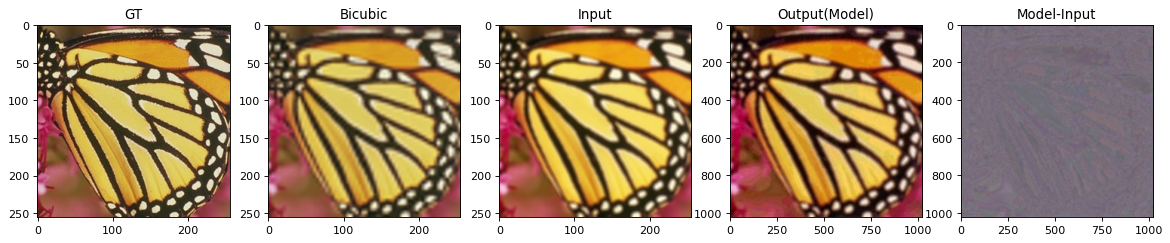

(None, 27.899609393357878, 97.89891300513409)

In [146]:
display_PSNR(im_gt, im_b, im_b2, model, channels=3)


In [147]:
from superres_utils import is_image_file

In [148]:
# Make this load still photos too, and have them added with frame = 0
def test_results(test_dir,scale, model, channels=1, display = False):
    instances = []
    psnr_bicubic_sum = 0
    psnr_model_sum = 0
    ct = 0
    
    for filename in listdir(test_dir):
        filepath = os.path.join(test_dir,filename)
        #print(filepath)
                
        if is_image_file(filepath):
            im_gt = Image.open(filepath).convert("RGB")
            #print(im_gt.size)
            
            (height, width) = im_gt.size
            im_b = im_gt.resize((int(2*height/scale), int(2*width/scale)), resample = Image.BICUBIC)
            im_b = im_b.resize((height,width), resample = Image.BICUBIC)
            im_b2 = pil_disk_blur(im_gt,scale)
            
            im_h, psnr_bicubic, psnr_predicted = display_PSNR(im_gt, im_b, im_b2, model, channels=channels, display = display)
            psnr_bicubic_sum = psnr_bicubic_sum + psnr_bicubic
            psnr_model_sum = psnr_model_sum + psnr_predicted
            ct = ct +1
            #item = {"Filepath":filepath, "Type":"image"}
            #instances.append(item)
        
    psnr_bicubic_avg = psnr_bicubic_sum / ct
    psnr_model_avg = psnr_model_sum / ct
        
    print("Bicubic average PSNR =",psnr_bicubic_avg)
    print("Model average PSNR =",psnr_model_avg)
    return 




im_input.shape= torch.Size([1, 3, 480, 500])
out= torch.Size([1, 3, 1920, 2000])
im.h.shape= (1920, 2000, 3)
psnr for bicubic is 29.036801035746436dB
psnr for input is 28.851716274007487dB
psnr for Model is 28.025976664813395dB
PSNR improvement is -0.8257396091940912dB
Sharpness Measurement GroundTruth: 5109.0955266965975
Sharpness Measurement Bicubic: 15.83579055305556
Sharpness Measurement Input: 25.691640592899297
Sharpness Measurement Model: 208.61911737655285
Estimate of kernel: None
(1920, 2000)


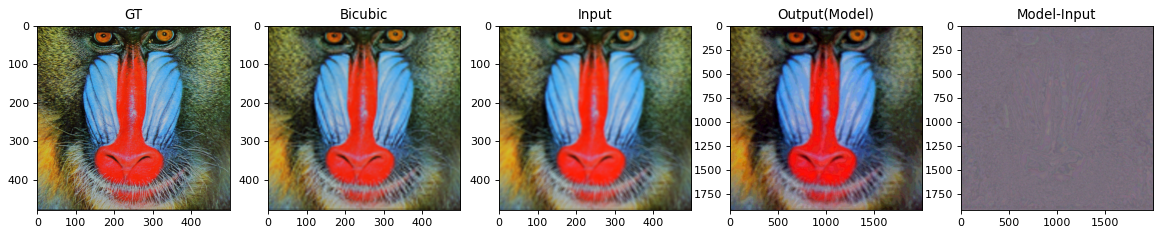

im_input.shape= torch.Size([1, 3, 362, 500])
out= torch.Size([1, 3, 1448, 2000])
im.h.shape= (1448, 2000, 3)
psnr for bicubic is 31.11803408582068dB
psnr for input is 30.762933621485097dB
psnr for Model is 28.081431064039073dB
PSNR improvement is -2.6815025574460236dB
Sharpness Measurement GroundTruth: 1139.0247193743783
Sharpness Measurement Bicubic: 22.619108417905434
Sharpness Measurement Input: 13.80918742745948
Sharpness Measurement Model: 198.8080067360095
Estimate of kernel: None
(1448, 2000)


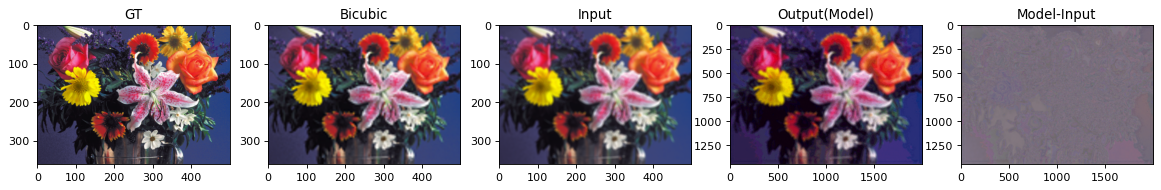

im_input.shape= torch.Size([1, 3, 512, 512])
out= torch.Size([1, 3, 2048, 2048])
im.h.shape= (2048, 2048, 3)
psnr for bicubic is 32.55898658402302dB
psnr for input is 30.195750331010412dB
psnr for Model is 27.249018716827884dB
PSNR improvement is -2.9467316141825286dB
Sharpness Measurement GroundTruth: 497.13785915203334
Sharpness Measurement Bicubic: 11.100006092106923
Sharpness Measurement Input: 8.121845194706111
Sharpness Measurement Model: 183.8857547203193
Estimate of kernel: None
(2048, 2048)


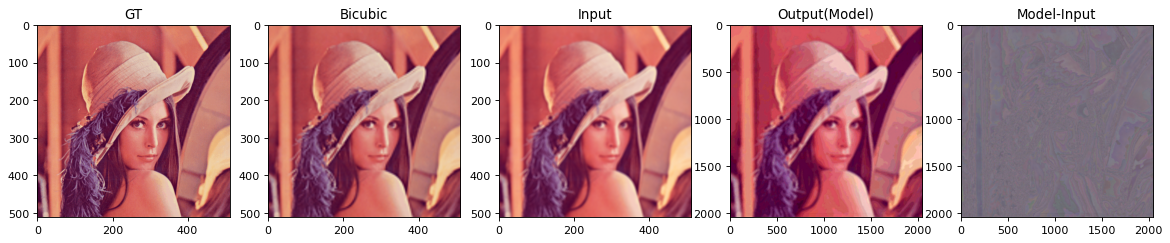

im_input.shape= torch.Size([1, 3, 360, 250])
out= torch.Size([1, 3, 1440, 1000])
im.h.shape= (1440, 1000, 3)
psnr for bicubic is 29.369266510382424dB
psnr for input is 28.99954548836702dB
psnr for Model is 27.987553281822038dB
PSNR improvement is -1.0119922065449813dB
Sharpness Measurement GroundTruth: 3181.438977407284
Sharpness Measurement Bicubic: 37.289469999876545
Sharpness Measurement Input: 28.37804635444444
Sharpness Measurement Model: 222.9779947386069
Estimate of kernel: None
(1440, 1000)


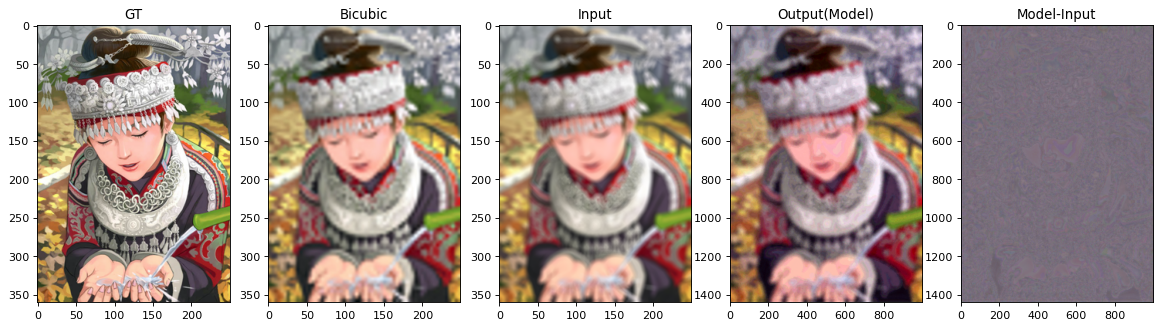

im_input.shape= torch.Size([1, 3, 276, 276])
out= torch.Size([1, 3, 1104, 1104])
im.h.shape= (1104, 1104, 3)
psnr for bicubic is 31.692397011541043dB
psnr for input is 31.124429204780093dB
psnr for Model is 28.103363384184085dB
PSNR improvement is -3.0210658205960073dB
Sharpness Measurement GroundTruth: 595.7572052363794
Sharpness Measurement Bicubic: 5.924464354118902
Sharpness Measurement Input: 5.381457678695719
Sharpness Measurement Model: 127.76206342121823
Estimate of kernel: None
(1104, 1104)


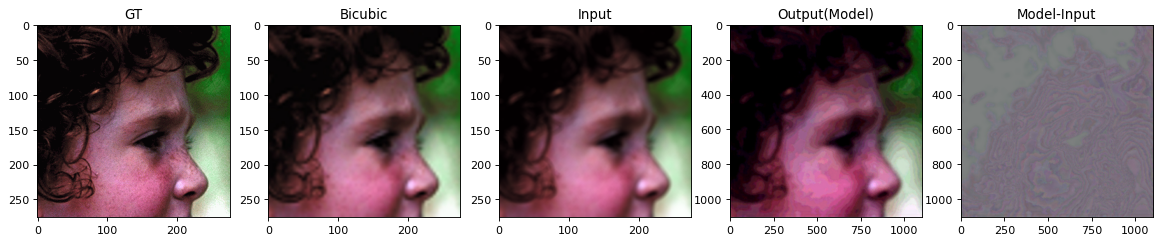

im_input.shape= torch.Size([1, 3, 512, 512])
out= torch.Size([1, 3, 2048, 2048])
im.h.shape= (2048, 2048, 3)
psnr for bicubic is 29.605765597732425dB
psnr for input is 29.37140939839984dB
psnr for Model is 27.429923684062267dB
PSNR improvement is -1.941485714337574dB
Sharpness Measurement GroundTruth: 2376.0941899851314
Sharpness Measurement Bicubic: 19.785036861649132
Sharpness Measurement Input: 17.199081368511543
Sharpness Measurement Model: 201.6200326175487
Estimate of kernel: None
(2048, 2048)


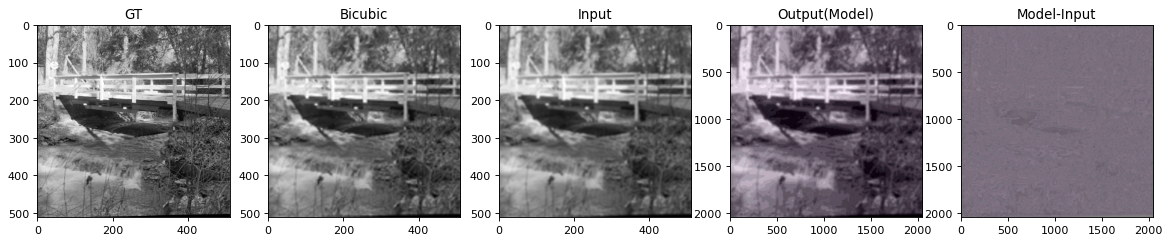

im_input.shape= torch.Size([1, 3, 390, 586])
out= torch.Size([1, 3, 1560, 2344])
im.h.shape= (1560, 2344, 3)
psnr for bicubic is 30.035798689106578dB
psnr for input is 29.555144014865427dB
psnr for Model is 28.23545070578861dB
PSNR improvement is -1.3196933090768148dB
Sharpness Measurement GroundTruth: 938.4126397093572
Sharpness Measurement Bicubic: 44.872761652286144
Sharpness Measurement Input: 22.874262611870485
Sharpness Measurement Model: 239.3137873164447
Estimate of kernel: None
(1560, 2344)


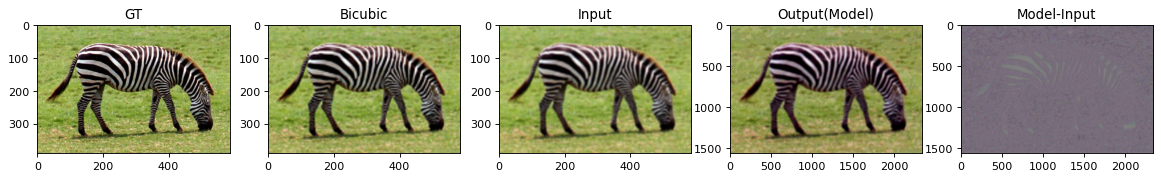

im_input.shape= torch.Size([1, 3, 656, 528])
out= torch.Size([1, 3, 2624, 2112])
im.h.shape= (2624, 2112, 3)
psnr for bicubic is 33.022681197364605dB
psnr for input is 32.849247653427284dB
psnr for Model is 29.689652408420237dB
PSNR improvement is -3.159595245007047dB
Sharpness Measurement GroundTruth: 1927.3090995493055
Sharpness Measurement Bicubic: 39.040601296742174
Sharpness Measurement Input: 24.473614524373588
Sharpness Measurement Model: 187.4547865866224
Estimate of kernel: None
(2624, 2112)


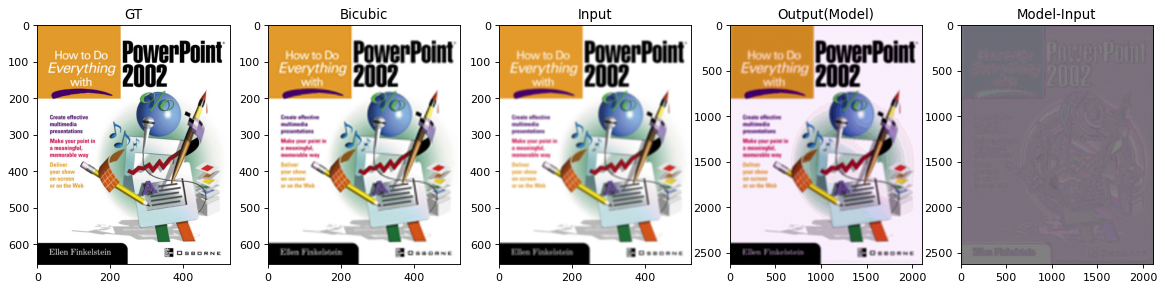

im_input.shape= torch.Size([1, 3, 288, 352])
out= torch.Size([1, 3, 1152, 1408])
im.h.shape= (1152, 1408, 3)
psnr for bicubic is 33.13029507805908dB
psnr for input is 29.511766658384975dB
psnr for Model is 28.047187864696586dB
PSNR improvement is -1.4645787936883892dB
Sharpness Measurement GroundTruth: 739.6683709929154
Sharpness Measurement Bicubic: 15.413530136928086
Sharpness Measurement Input: 11.780609417224392
Sharpness Measurement Model: 208.5114606687708
Estimate of kernel: None
(1152, 1408)


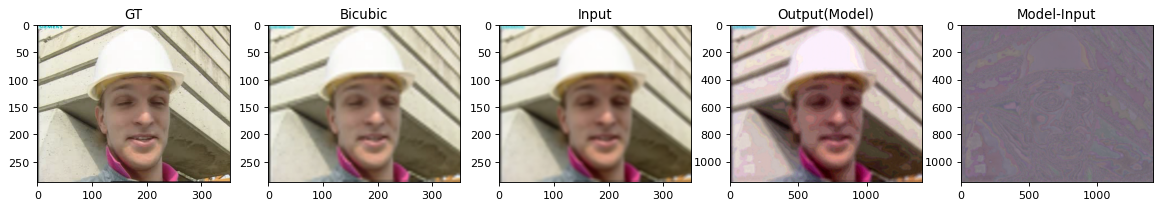

im_input.shape= torch.Size([1, 3, 512, 768])
out= torch.Size([1, 3, 2048, 3072])
im.h.shape= (2048, 3072, 3)
psnr for bicubic is 33.916186184763596dB
psnr for input is 30.024336643345215dB
psnr for Model is 27.7894813216852dB
PSNR improvement is -2.2348553216600138dB
Sharpness Measurement GroundTruth: 625.6135935834542
Sharpness Measurement Bicubic: 21.235857645612366
Sharpness Measurement Input: 16.119284426269587
Sharpness Measurement Model: 223.35305583244383
Estimate of kernel: None
(2048, 3072)


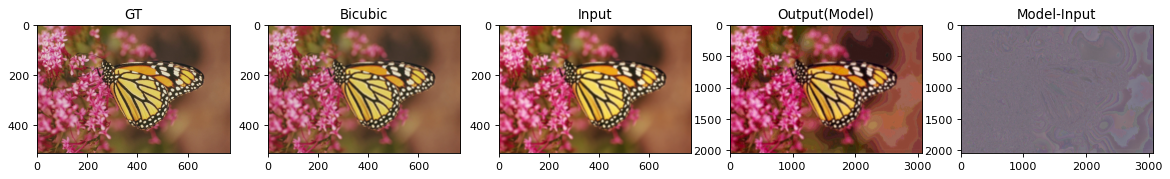

im_input.shape= torch.Size([1, 3, 512, 512])
out= torch.Size([1, 3, 2048, 2048])
im.h.shape= (2048, 2048, 3)
psnr for bicubic is 32.48232705277284dB
psnr for input is 28.865984766085887dB
psnr for Model is 28.008399211902216dB
PSNR improvement is -0.8575855541836717dB
Sharpness Measurement GroundTruth: 785.671896489439
Sharpness Measurement Bicubic: 10.848251492236159
Sharpness Measurement Input: 9.1864211349166
Sharpness Measurement Model: 207.66823982260502
Estimate of kernel: None
(2048, 2048)


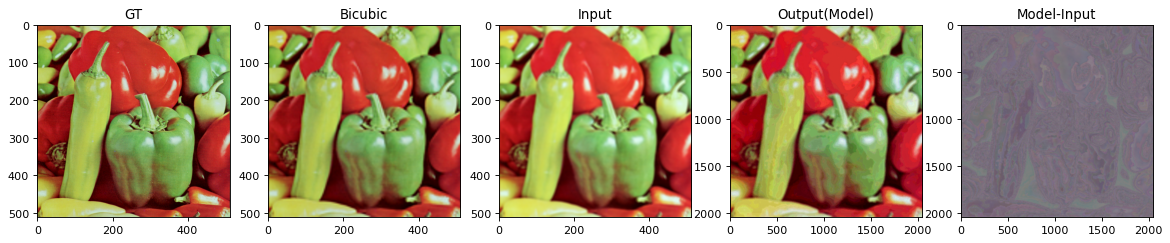

im_input.shape= torch.Size([1, 3, 288, 352])
out= torch.Size([1, 3, 1152, 1408])
im.h.shape= (1152, 1408, 3)
psnr for bicubic is 29.950692497386193dB
psnr for input is 29.75471673746449dB
psnr for Model is 28.111771162266884dB
PSNR improvement is -1.6429455751976079dB
Sharpness Measurement GroundTruth: 1044.1713580036271
Sharpness Measurement Bicubic: 11.743170487662988
Sharpness Measurement Input: 10.18928856485268
Sharpness Measurement Model: 189.5689536026026
Estimate of kernel: None
(1152, 1408)


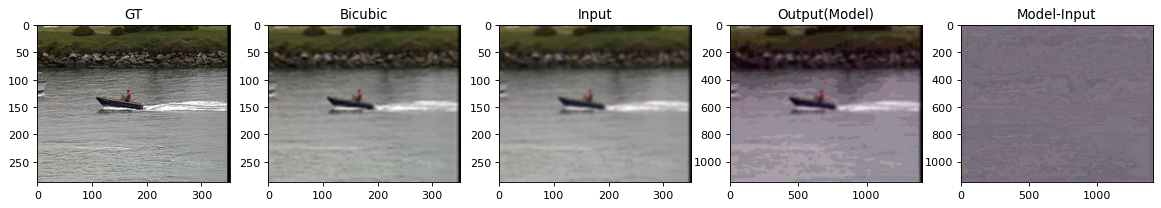

im_input.shape= torch.Size([1, 3, 512, 512])
out= torch.Size([1, 3, 2048, 2048])
im.h.shape= (2048, 2048, 3)
psnr for bicubic is 30.823560798013602dB
psnr for input is 28.59396998387945dB
psnr for Model is 27.82893402674283dB
PSNR improvement is -0.7650359571366216dB
Sharpness Measurement GroundTruth: 1773.856239214525
Sharpness Measurement Bicubic: 18.433340376010165
Sharpness Measurement Input: 18.29750663577579
Sharpness Measurement Model: 174.3476212187466
Estimate of kernel: None
(2048, 2048)


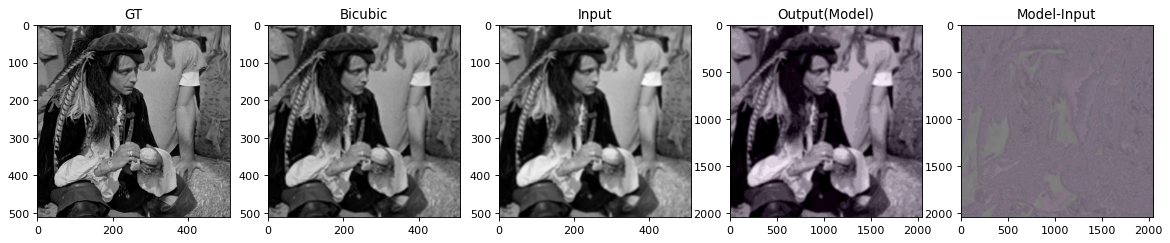

im_input.shape= torch.Size([1, 3, 576, 720])
out= torch.Size([1, 3, 2304, 2880])
im.h.shape= (2304, 2880, 3)
psnr for bicubic is 30.95415254385844dB
psnr for input is 30.242393527755517dB
psnr for Model is 27.92862838771518dB
PSNR improvement is -2.3137651400403385dB
Sharpness Measurement GroundTruth: 1943.9403096163192
Sharpness Measurement Bicubic: 13.533079124837908
Sharpness Measurement Input: 12.197453795097127
Sharpness Measurement Model: 187.559278077464
Estimate of kernel: None
(2304, 2880)


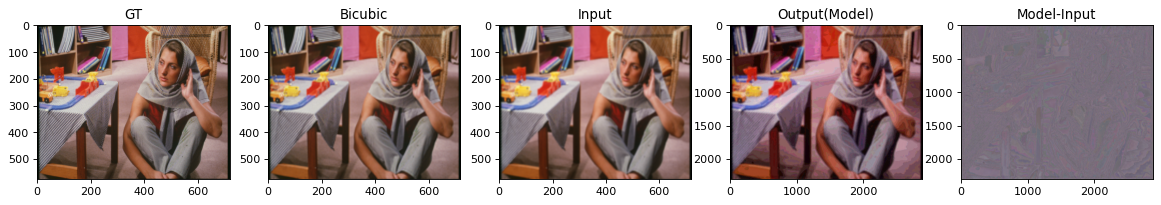

Bicubic average PSNR = 28.036912277497606
Model average PSNR = 15.978549980506918


In [151]:
test_results("/media/SSD/superres/video_data/test_data/Set14", 8, model, channels=3,display = True)

# convert sample videos

In [152]:
import kornia as K

In [153]:
img = cv2.imread("/home/filip/Pictures/Screenshot from sup8snip.mp4.png")  # HxWx3
img.shape

(480, 640, 3)

In [154]:

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_rgb = cv2.resize(img_rgb, (640, 240), interpolation=cv2.INTER_LANCZOS4)
img_rgb = cv_center_crop(img_rgb,48)
img_t = K.image_to_tensor(img_rgb,keepdim=False).cuda().half().clamp(0,250)  # 1x3xHxW
#img_t = img_t.float() / 255.


NameError: name 'cv_center_crop' is not defined

In [57]:
img_t.shape

torch.Size([1, 3, 48, 48])

In [58]:
from torch.cuda.amp import autocast

In [59]:
with autocast():
    out = model(img_t)

In [60]:
out.shape

torch.Size([1, 3, 192, 192])

In [61]:
#out = (out/255).byte().clamp(0,255)

In [62]:
img_out: np.ndarray = K.tensor_to_image(out.byte().clamp(0,255))  # HxWxC

In [63]:
img_out.shape

(192, 192, 3)

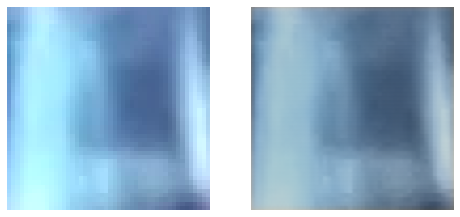

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
axs = axs.ravel()

axs[0].axis('off')
axs[0].imshow(img_rgb)

axs[1].axis('off')
axs[1].imshow(img_out)

In [ ]:
windows = img_t.unfold(dimension=2,size=48, step = 48).unfold(dimension=3,size=48, step = 48)

In [ ]:
img_t.shape

In [ ]:
windows.shape

In [ ]:
img_t = windows.reshape(-1, 3, 48, 48)

In [ ]:
img_t.shape

In [65]:
img = cv2.imread("/home/filip/Pictures/Screenshot from sup8snip.mp4.png")  # HxWx3
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rgb = cv2.resize(img_rgb, (320, 240), interpolation=cv2.INTER_CUBIC)
#img_rgb = cv_center_crop(img_rgb,48)
img_t = K.image_to_tensor(img_rgb,keepdim=False).cuda().half().clamp(0,250)  # 1x3xHxW

In [66]:
img_rgb.shape

(240, 320, 3)

In [67]:
img_t.shape

torch.Size([1, 3, 240, 320])

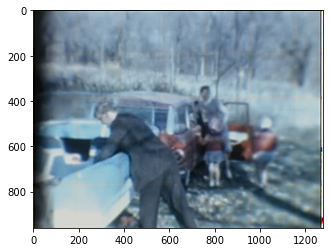

In [68]:
(x0,x1,x2,x3) = img_t.shape
scale = 4


res = np.zeros((x2*scale, x3*scale,3),dtype = int)
for t in range(0,x3,48):
    for s in range(0,x2,48):
        #print(s,t)
        tbatch = img_t[:,:,s:s+48,t:t+48]
        #print(tbatch.shape)
        with autocast():
            out = model(tbatch)
        
        img_out: np.ndarray = K.tensor_to_image(out.byte().clamp(0,255))  # HxWxC
        
        s_scaled = s*4
        (d0,d1,d2) = img_out.shape
        t_scaled = t*4
        res[s_scaled:s_scaled+d0,t_scaled:t_scaled+d1,:] = img_out
plt.imshow(res)

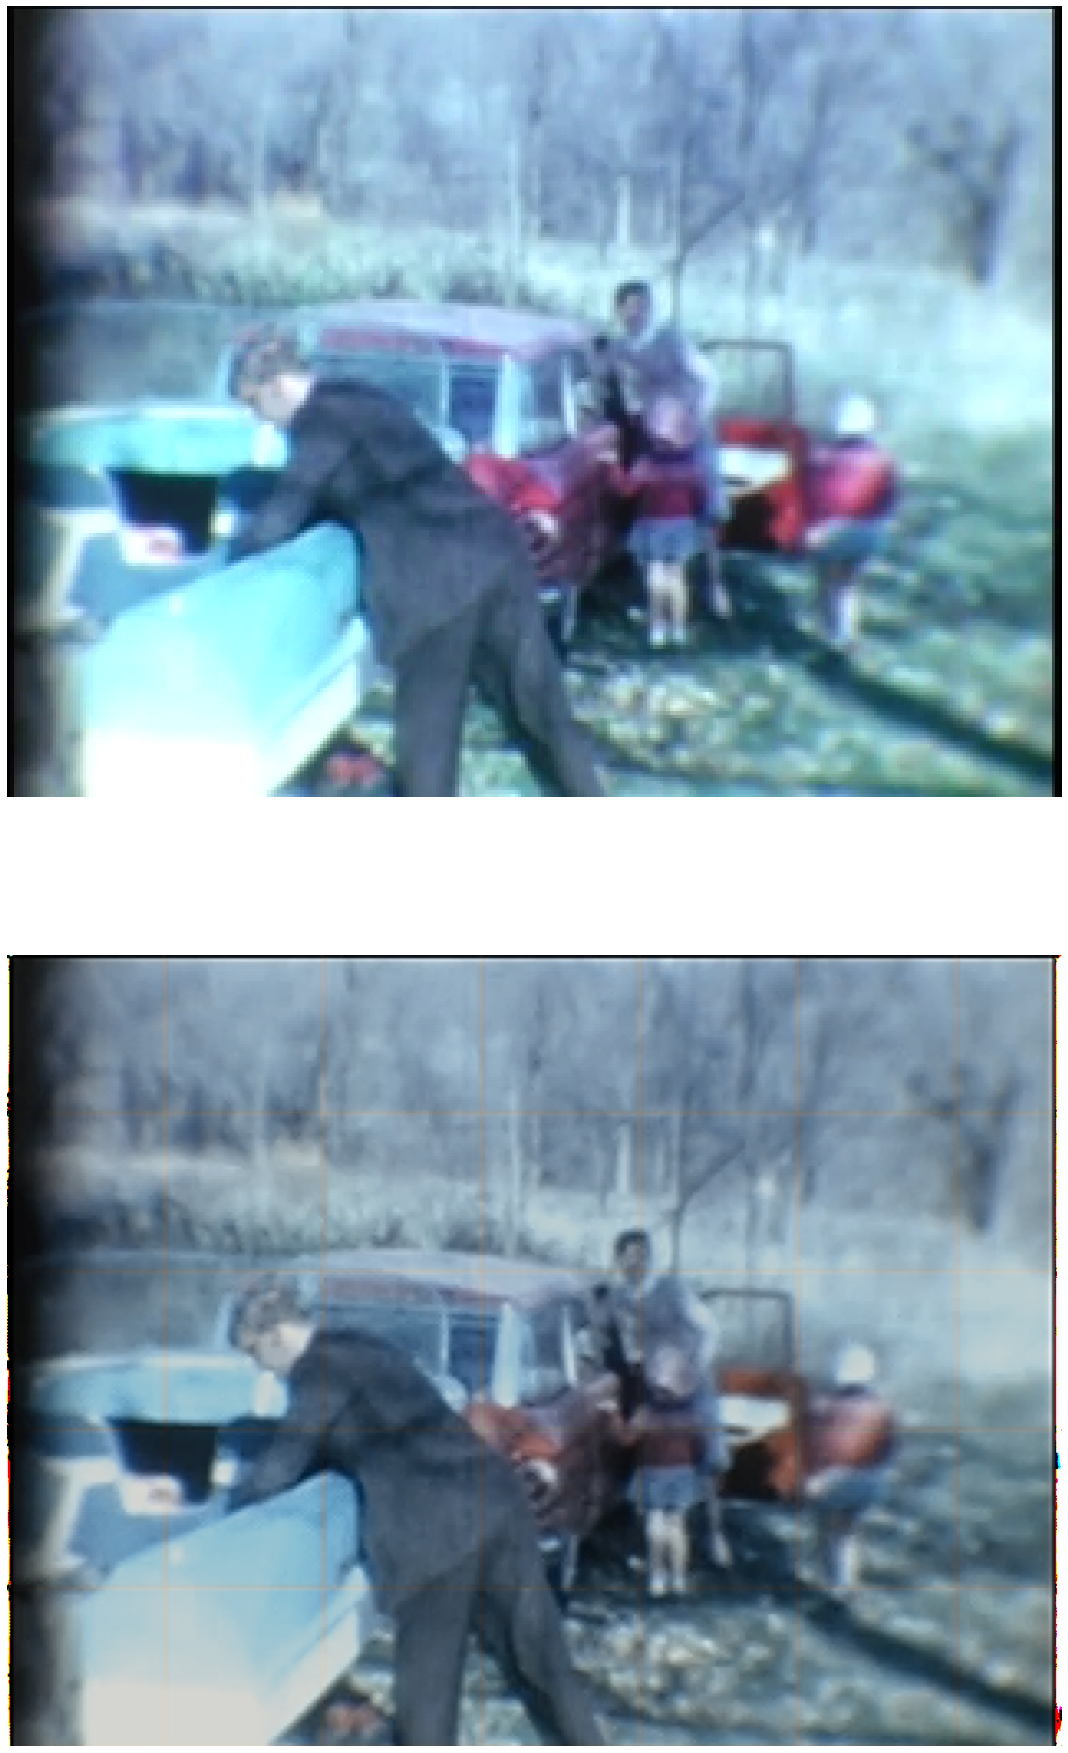

In [69]:
fig, axs = plt.subplots(2, 1, figsize=(32, 32))
axs = axs.ravel()

axs[0].axis('off')
axs[0].imshow(img_rgb)

axs[1].axis('off')
axs[1].imshow(res)

In [ ]:
from torchvision.utils import make_grid
gr = make_grid(out, nrow = 1, padding= 0, normalize = True)

In [ ]:
gr.shape

In [ ]:
img_out: np.ndarray = K.tensor_to_image(gr.byte().clamp(0,255))  # HxWxC

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
axs = axs.ravel()

axs[0].axis('off')
axs[0].imshow(img_rgb)

axs[1].axis('off')
axs[1].imshow(img_out)

In [ ]:
x = []
for _ in range(10):
    x.append(torch.randn(3, 224, 224))
x = torch.stack(x)

In [ ]:
from torch.cuda.amp import autocast
def superres_3chan_mp4(infile, outfile, model, prescale_factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    
    # need to take into account model 48x48
    new_height = int(height*prescale_factor)
    new_width = int(width*prescale_factor)
    
    print("\nProcess File:", str(outfile))
    print("prescale_factor:",prescale_factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (prescale_factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
                
            # convert cv image to pytorch image   
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

In [ ]:
result_path

In [ ]:


infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-12.mp4"
superres_mp4(infile, outfile, model, factor=1.2,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

In [ ]:
dualfile= str(result_path/"muffins30sec-10dual.mp4")
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = str(result_path/"muffins30sec-10.mp4")

In [ ]:
# original scale , for video x3
!ffmpeg  -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw:ih [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

In [ ]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = result_path/"muffins30sec-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


In [ ]:
dualfile= str(result_path/"muffins30sec-30dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = result_path/"super8.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:

dualfile = str(result_path/"super8dual.mp4")
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train espcn with hres perception loss multifuz/super8hespcn1.mp4"
outfile = str(result_path/"super8.mp4")
dualfile= str(result_path/"super8-tolast-dual.mp4")

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = result_file/"super8long.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

In [ ]:
dualfile= folder + "super8longespcn2dual.mp4"
infile = str(infile)
outfile = str(outfile)

In [ ]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}